# **COVID-19 PREDICTOR**

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

     |████████████████████████████████| 1.4 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 39.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## **Data Preprocessing and Summarization**

In [ ]:
state_test = pd.read_csv('StatewiseTestingDetails.csv')
state_vacc = pd.read_csv('covid_vaccine_statewise.csv')
covid = pd.read_csv('covid_19_india.csv')

In [ ]:
covid.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [ ]:
state_test.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [ ]:
state_vacc.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),Sputnik V (Doses Administered),AEFI,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,NaN,NaN,NaN,579.0,47697.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23757.0,24517.0,2.0,48276.0
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,NaN,NaN,NaN,635.0,57969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27348.0,31252.0,4.0,58604.0
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,NaN,NaN,NaN,1299.0,98150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41361.0,58083.0,5.0,99449.0
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,NaN,NaN,NaN,3017.0,192508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81901.0,113613.0,11.0,195525.0
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,NaN,NaN,NaN,3946.0,247334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98111.0,153145.0,24.0,251280.0


In [ ]:
covid.columns = ['Sno', 'Date', 'Time', 'State', 'CnfrmIndian', 'CnfrmForeign', 'Cured', 'Death', 'Confirmed']
state_vacc.columns = [x.strip().replace(' ','_') for x in state_vacc.columns]

state_vacc['Updated_On'] = pd.to_datetime(state_vacc['Updated_On'], format='%d/%m/%Y')
state_vacc['Month'] = state_vacc['Updated_On'].dt.month
month_val = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
month = {i+1:x for i,x in enumerate(month_val)}
state_vacc['Month'] = state_vacc['Month'].map(month)
#state_vacc['Updated_On'] = state_vacc['Updated_On'].astype(str)
#state_vacc['Month'] = state_vacc['Updated_On'].apply(lambda x:x.split('-')[0]) + state_vacc['Month']

covid['Date'] = pd.to_datetime(covid['Date'], format='%Y/%m/%d')
covid['Month'] = covid['Date'].dt.month
month_val_new = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
month = {i+1:x for i,x in enumerate(month_val_new)}
covid['Month'] = covid['Month'].map(month)
#covid['Date'] = covid['Date'].astype(str)
#covid['Month'] = covid['Date'].apply(lambda x:x.split('-')[0]) + covid['Month']

STATE = 'Kerala'

In [ ]:
state_test['State'].unique()

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype=object)

In [ ]:
print(state_test['Date'].min())
print(state_test['Date'].max())

2020-04-01
2021-08-10


In [ ]:
print(state_vacc['Updated_On'].min())
print(state_vacc['Updated_On'].max())

2021-01-16 00:00:00
2021-08-16 00:00:00


In [ ]:
state_test['Negative'] = state_test['Negative'].astype(str)
state_test['Negative'] = state_test['Negative'].apply(lambda x:x.replace('nan','-1'))
state_test['Negative'] = state_test['Negative'].apply(lambda x:x.replace(' ','-1'))
state_test['Negative'] = state_test['Negative'].astype(int)

covid['CnfrmIndian'] = covid['CnfrmIndian'].astype(str)
covid['CnfrmIndian'] = covid['CnfrmIndian'].apply(lambda x:x.replace('-','0'))
covid['CnfrmIndian'] = covid['CnfrmIndian'].astype(int)

covid['CnfrmForeign'] = covid['CnfrmForeign'].astype(str)
covid['CnfrmForeign'] = covid['CnfrmForeign'].apply(lambda x:x.replace('-','0'))
covid['CnfrmForeign'] = covid['CnfrmForeign'].astype(int)

covid['State']=covid['State'].replace(['Bihar****','Madhya Pradesh***','Maharashtra***','Karanataka'],['Bihar','Madhya Pradesh','Maharashtra','Karnataka'])

In [ ]:
state_test['TotalSamples']=state_test['TotalSamples'].fillna(0)
state_test['TotalSamples']=state_test['TotalSamples'].astype('int')
state_test['Positive']=state_test['Positive'].fillna(0)
state_test['Positive']=state_test['Positive'].astype('int')
state_test['Negative']=state_test['Negative'].fillna(0)
#state_testing['Negative']=state_testing['Negative'].astype('int')
state_test['Date'] = pd.to_datetime(state_test['Date'], format='%Y/%m/%d')

In [ ]:
state_vacc['FDA_Each_Day']=state_vacc.groupby('State',sort=True)['First_Dose_Administered'].diff().reset_index(drop=True)
state_vacc['SDA_Each_Day']=state_vacc.groupby('State',sort=True)['Second_Dose_Administered'].diff().reset_index(drop=True)
covid['Confirmed_Each_Day']=covid.groupby('State',sort=True)['Confirmed'].diff().reset_index(drop=True)
covid['Death_Each_Day']=covid.groupby('State',sort=True)['Death'].diff().reset_index(drop=True)
state_vacc[state_vacc['State']=='Kerala'][['Updated_On','State','First_Dose_Administered','FDA_Each_Day']].head(10)

,Updated_On,State,First_Dose_Administered,FDA_Each_Day
3605,2021-01-16,Kerala,1681.0,NaN
3606,2021-01-17,Kerala,1836.0,155.0
3607,2021-01-18,Kerala,2566.0,730.0
3608,2021-01-19,Kerala,5355.0,2789.0
3609,2021-01-20,Kerala,5398.0,43.0
3610,2021-01-21,Kerala,9175.0,3777.0
3611,2021-01-22,Kerala,15501.0,6326.0
3612,2021-01-23,Kerala,21944.0,6443.0
3613,2021-01-24,Kerala,23324.0,1380.0
3614,2021-01-25,Kerala,43561.0,20237.0


##**Data Visualization**

In [ ]:
df=covid
df['Active_cases']=df['Confirmed']-(df['Cured']+df['Death'])

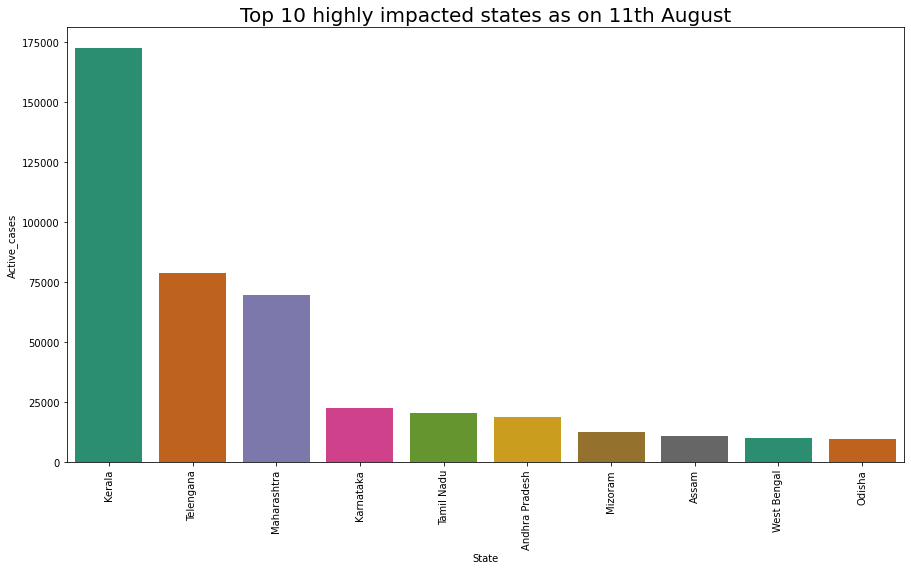

In [ ]:
top_10=df.groupby(by='State').last()[['Active_cases','Date']].sort_values(by=['Active_cases'],ascending=False).reset_index()
fig=plt.figure(figsize=(15,8))
plt.title("Top 10 highly impacted states as on 11th August", size=20)
ax=sns.barplot(data=top_10.iloc[:10],y='Active_cases',x='State', linewidth=2, palette='Dark2')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
covid['State'].unique()

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya',
       'Dadra and Nagar Haveli and Daman and Diu',
       'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
       'Lakshadweep', 'Telangana', 'Dadra and Nagar Haveli',
       'Himanchal Pradesh'], dtype=object)

Text(0.5, 1.0, 'Active cases by States')

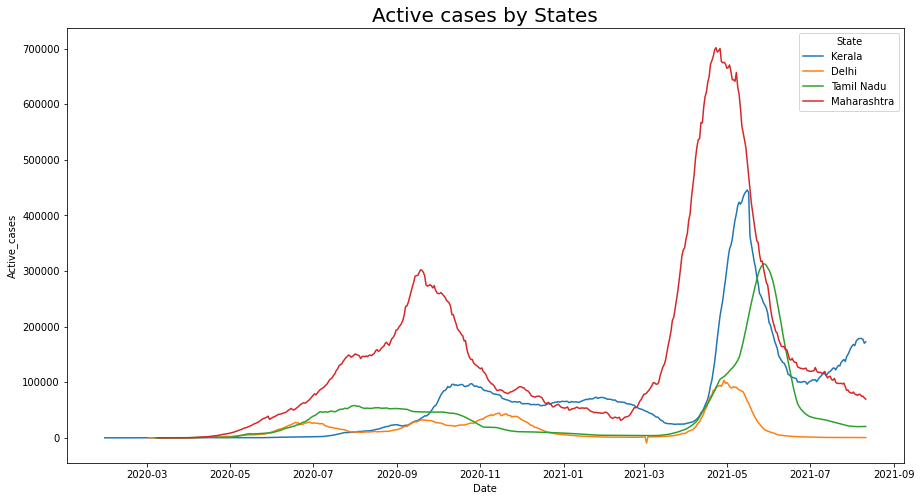

In [ ]:
fig=plt.figure(figsize=(15,8))
ax=sns.lineplot(data=df[df['State'].isin(['Kerala','Tamil Nadu','Delhi','Maharashtra'])],x='Date',y='Active_cases',hue='State')
ax.set_title("Active cases by States", size=20)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
median_states=df[df['State'].isin(['Kerala','Tamil Nadu','Delhi','Maharashtra'])]
median_states['Cured/Deaths']=df['Cured']+df['Death']
median_states.groupby(by=['State']).median()

,Sno,CnfrmIndian,CnfrmForeign,Cured,Death,Confirmed,Confirmed_Each_Day,Death_Each_Day,Active_cases,Cured/Deaths
State,,,,,,,,,,
Delhi,8617.5,0.0,0.0,463755.5,8100.0,513934.0,1024.0,18.0,10110.0,471855.5
Kerala,8065.5,0.0,0.0,368848.0,1573.0,455388.0,3459.0,16.0,46928.5,370421.0
Maharashtra,8751.0,0.0,0.0,1654793.0,46653.0,1784361.0,6665.0,137.0,96548.0,1701446.0
Tamil Nadu,8726.0,0.0,0.0,745848.0,11605.0,769995.0,2100.5,26.0,20407.0,757453.0


Text(0.5, 1.0, 'Bar plot for sample states')

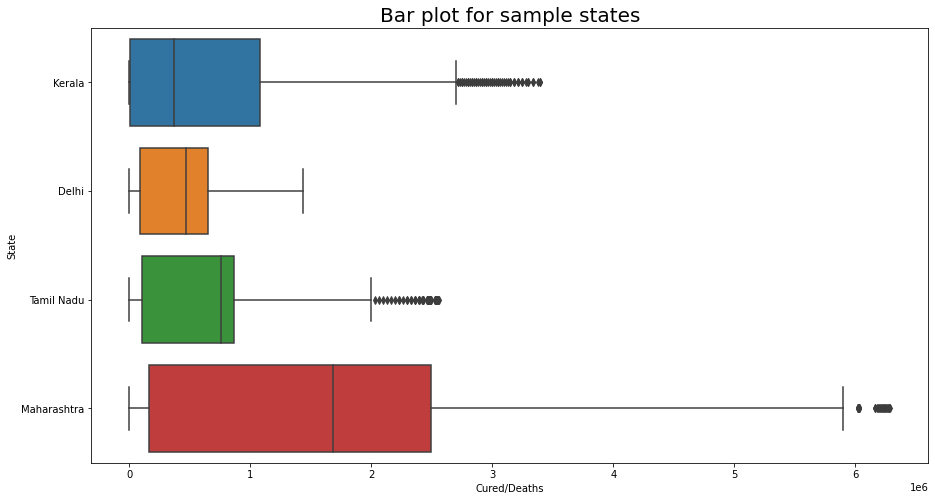

In [ ]:
fig=plt.figure(figsize=(15,8))
sns.boxplot(data=df[df['State'].isin(['Kerala','Tamil Nadu','Delhi','Maharashtra'])],x=(df.Cured | df.Death),y='State')
plt.xlabel('Cured/Deaths')
plt.title("Bar plot for sample states" ,size=20)

In [ ]:
median_states.groupby(by=['State']).median()

,Sno,CnfrmIndian,CnfrmForeign,Cured,Death,Confirmed,Confirmed_Each_Day,Death_Each_Day,Active_cases,Cured/Deaths
State,,,,,,,,,,
Delhi,8617.5,0.0,0.0,463755.5,8100.0,513934.0,1024.0,18.0,10110.0,471855.5
Kerala,8065.5,0.0,0.0,368848.0,1573.0,455388.0,3459.0,16.0,46928.5,370421.0
Maharashtra,8751.0,0.0,0.0,1654793.0,46653.0,1784361.0,6665.0,137.0,96548.0,1701446.0
Tamil Nadu,8726.0,0.0,0.0,745848.0,11605.0,769995.0,2100.5,26.0,20407.0,757453.0


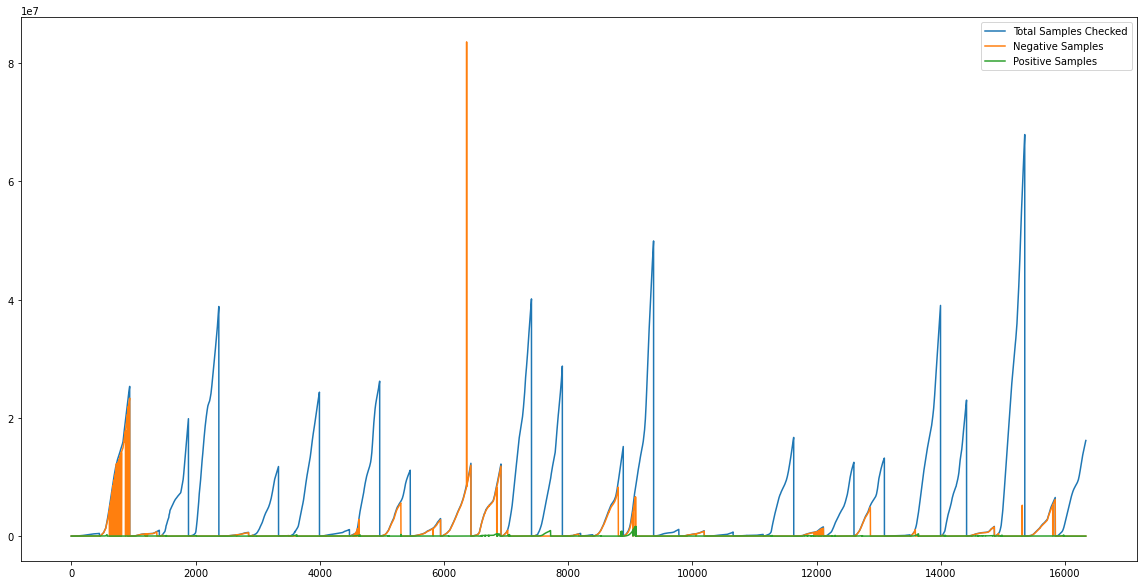

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(state_test['TotalSamples'], label='Total Samples Checked')
plt.plot(state_test['Negative'], label = 'Negative Samples')
plt.plot(state_test['Positive'], label = 'Positive Samples')
#plt.xticks([])
plt.legend()

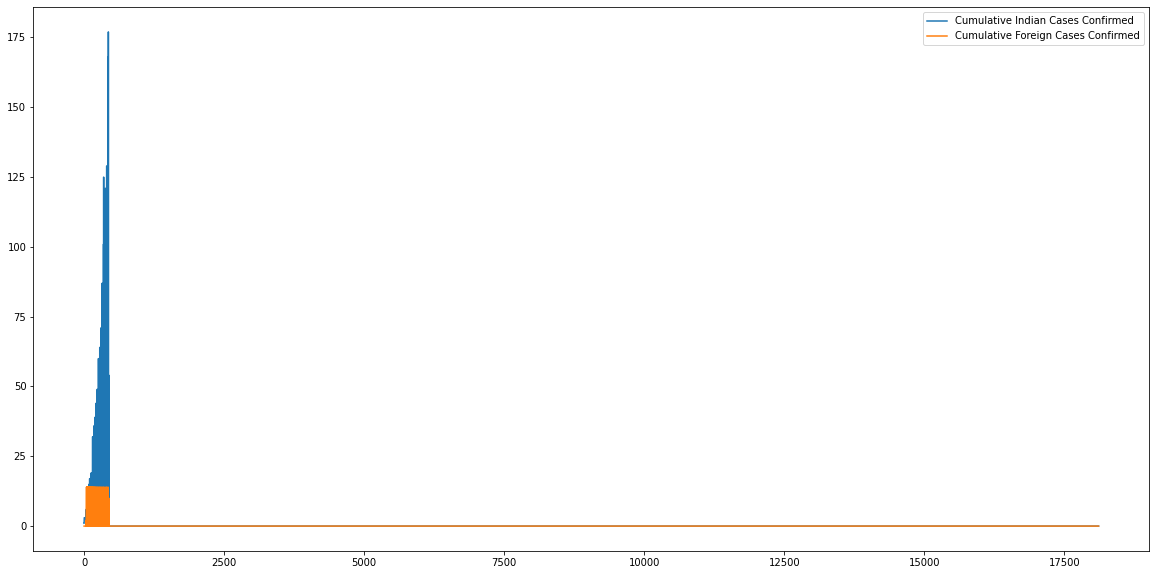

In [ ]:
#covid['Cumulative_Indians_Confirmed'] = covid['CnfrmIndian']
#covid['Cumulative_Foreign_Confirmed'] = covid['CnfrmForeign'].expanding().sum()

plt.figure(figsize=(20,10))
plt.plot(covid['CnfrmIndian'], label='Cumulative Indian Cases Confirmed')
plt.plot(covid['CnfrmForeign'], label='Cumulative Foreign Cases Confirmed')
#plt.xticks([])
plt.legend()

In [ ]:
#state_vacc[state_vacc['Updated_On'].dt.month==5]['Second_Dose_Administered'].max()
#state_vacc[state_vacc['State'] == 'Kerala'].groupby('Month')['Second_Dose_Administered'].max().sort_values("Name", axis = 0, ascending = True,
                 #inplace = True, na_position ='last')
covid[(covid['State'] == 'Goa') & (covid['Date'].dt.month==7) & (covid['Date'].dt.year>2020)][['Date','Confirmed','Confirmed_Each_Day']].sum()

Confirmed             5243316.0
Confirmed_Each_Day       4603.0
dtype: float64

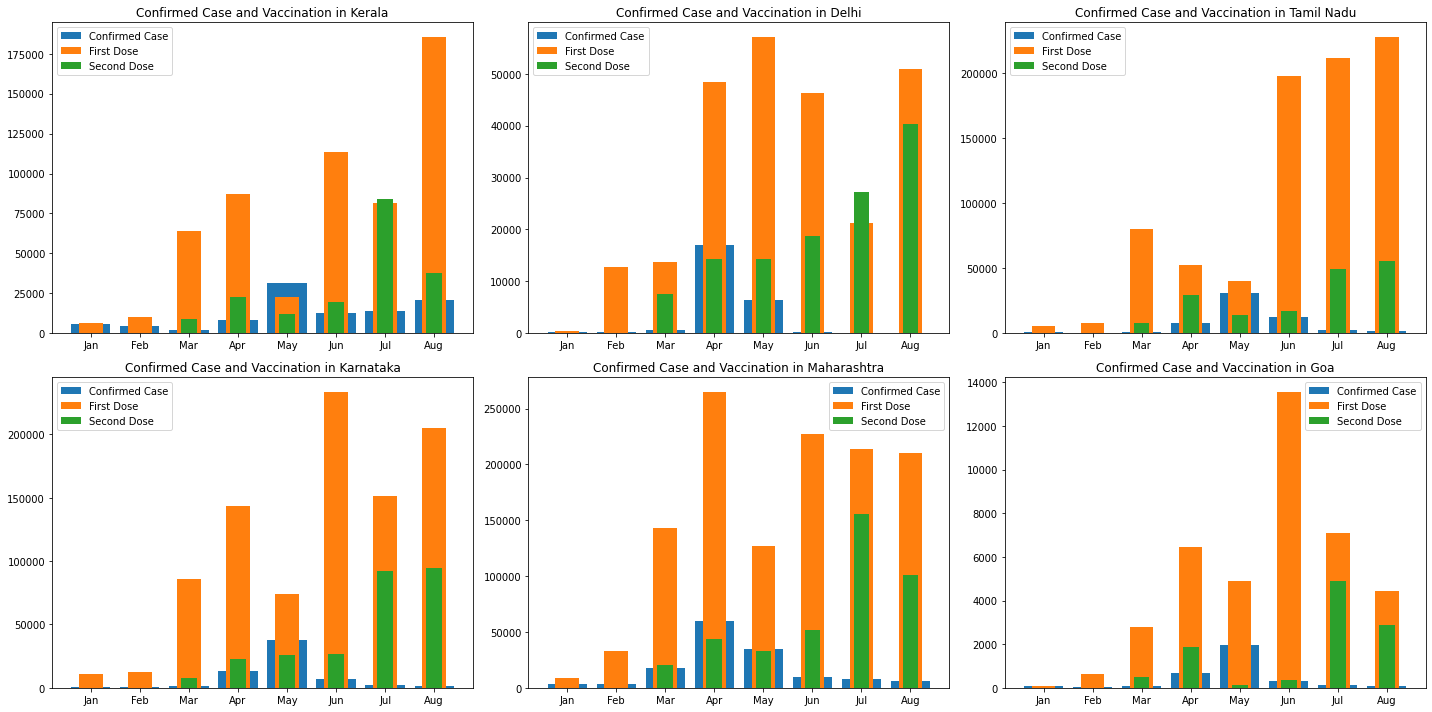

In [ ]:
states = ['Kerala', 'Delhi', 'Tamil Nadu', 'Karnataka', 'Maharashtra', 'Goa']
plt.figure(figsize=(20,10))
for i, s in enumerate(states):
    sv = state_vacc[state_vacc['State'] == s]
    cv = covid[(covid['State'] == s) & (covid['Date'].dt.year>2020)]
    
    total_dose_1 = sv.groupby('Month', sort=False)['FDA_Each_Day'].median()
    #total_dose_1 = total_dose_1.groupby('Month')
    total_dose_2 = sv.groupby('Month', sort=False)['SDA_Each_Day'].median()
    #total_dose_2 = total_dose_2.groupby('Month').max().values
    confirmed = cv.groupby('Month', sort=False)['Confirmed_Each_Day'].median()
    #confirmed = confirmed.groupby('Month').max().values
    
    _ = plt.subplot(2,3, i+1)
    _ = plt.title(f'Confirmed Case and Vaccination in {s}')
    _ = plt.bar(month_val, confirmed, label = 'Confirmed Case')
    _ = plt.bar(month_val, total_dose_1, label='First Dose', width=0.6*0.8)
    _ = plt.bar(month_val, total_dose_2, label='Second Dose', width=0.4*0.8)
    _ = plt.legend()
    #print(s,"\n")
    #print(confirmed,"\n")

_ = plt.tight_layout()
plt.show()

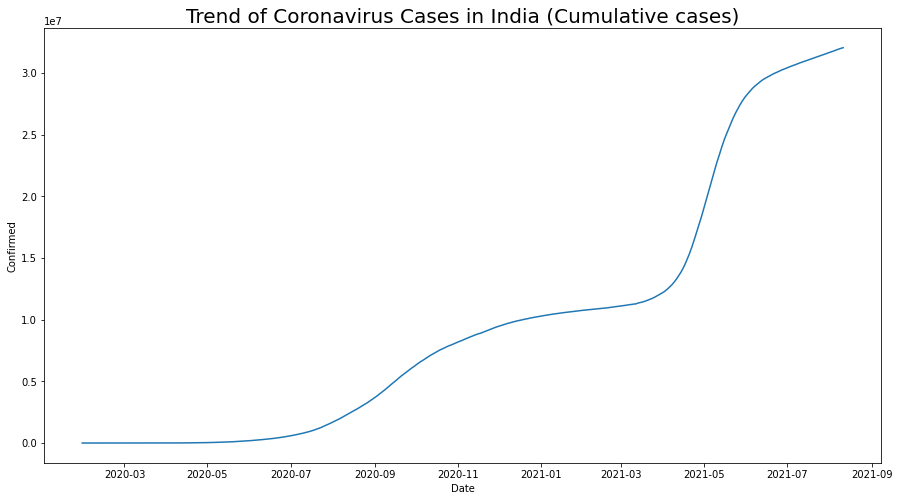

In [ ]:
new_covid = covid.groupby('Date')['Confirmed'].sum().reset_index()
fig = plt.figure(figsize=(15,8))
ax = sns.lineplot(data=new_covid,x='Date',y='Confirmed')
ax.set_title("Trend of Coronavirus Cases in India (Cumulative cases)", size=20)
plt.show()

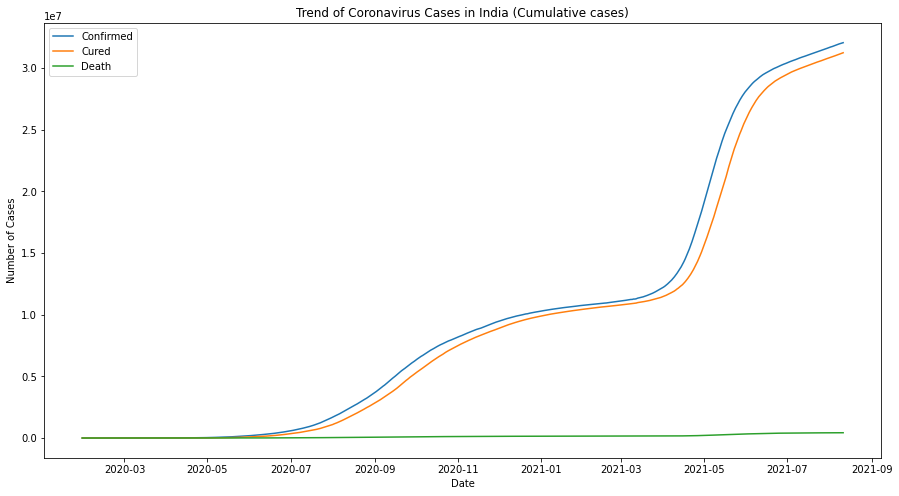

In [ ]:
new_covid = covid.groupby('Date')['Confirmed','Cured','Death'].sum().reset_index()
fig = plt.figure(figsize=(15,8))
plt.plot(new_covid['Date'],new_covid['Confirmed'])
plt.plot(new_covid['Date'],new_covid['Cured'])
plt.plot(new_covid['Date'],new_covid['Death'])
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(['Confirmed','Cured','Death'])
plt.title('Trend of Coronavirus Cases in India (Cumulative cases)')
plt.show()

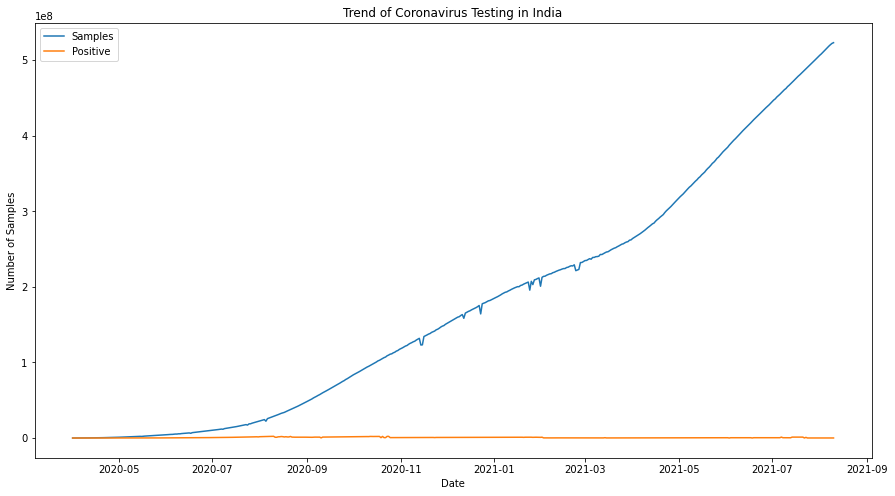

In [ ]:
new_state_test = state_test.groupby('Date')['TotalSamples','Positive'].sum().reset_index()
fig = plt.figure(figsize=(15,8))
plt.plot(new_state_test['Date'],new_state_test['TotalSamples'])
plt.plot(new_state_test['Date'],new_state_test['Positive'])
plt.xlabel('Date')
plt.ylabel('Number of Samples')
plt.legend(['Samples','Positive'])
plt.title('Trend of Coronavirus Testing in India')
plt.show()

In [ ]:
statewise = pd.pivot_table(covid, values=['Confirmed','Death','Cured'], index='State', aggfunc='max')
statewise['Recovery Rate'] = statewise['Cured']*100 / statewise['Confirmed']
statewise['Mortality Rate'] = statewise['Death']*100 /statewise['Confirmed']
statewise = statewise.sort_values(by='Confirmed', ascending= False)
statewise.style.background_gradient(cmap='YlOrRd')

,Confirmed,Cured,Death,Recovery Rate,Mortality Rate
State,,,,,
Maharashtra,6363442,6159676,134201,96.797865,2.108937
Kerala,3586693,3396184,18004,94.688450,0.501967
Karnataka,2921049,2861499,36848,97.961349,1.261465
Tamil Nadu,2579130,2524400,34367,97.877967,1.332504
Andhra Pradesh,1985182,1952736,13564,98.365591,0.683262
Uttar Pradesh,1708812,1685492,22775,98.635309,1.332797
West Bengal,1534999,1506532,18252,98.145471,1.189056
Delhi,1436852,1411280,25068,98.220276,1.744647
Chhattisgarh,1003356,988189,13544,98.488373,1.349870


In [ ]:
# statewise_testing = pd.pivot_table(state_test, values=['TotalSamples','Positive','Negative'], index='State', aggfunc='max')
# statewise_testing['Positive_Case_Rate'] = statewise_testing['Positive']*100 / statewise_testing['TotalSamples']
# statewise_testing['Positive_Case_Rate']=round(statewise_testing['Positive_Case_Rate'].astype('int'),2)
# statewise_testing = statewise_testing.sort_values(by='TotalSamples', ascending= False)
# statewise_testing.style.background_gradient(cmap='YlOrRd')
from google.colab import files
statewise.to_csv('file1.csv')
#files.download("file1.csv")

In [ ]:
testing=state_test.groupby('State')['TotalSamples'].max().sort_values(ascending=False).reset_index()
fig = px.bar(testing, 
             x="Total Samples",
             y="State", 
             orientation='h',
             height=800,
             title='Statewise Testing',
            color='State')
fig.show()

## **Data Prediction**

In [ ]:
#covid_new=covid.loc[covid["State"]=="Kerala"]

In [ ]:
Trend = covid.groupby(['Date'])['Confirmed', 'Death','Cured',].sum().reset_index()
Trend.head()

,Date,Confirmed,Death,Cured
0,2020-01-30,1,0,0
1,2020-01-31,1,0,0
2,2020-02-01,2,0,0
3,2020-02-02,3,0,0
4,2020-02-03,3,0,0


In [ ]:
Confirmed = Trend.loc[:, ['Date', 'Confirmed']] 
Confirmed.tail()

,Date,Confirmed
555,2021-08-07,31895385
556,2021-08-08,31934455
557,2021-08-09,31969954
558,2021-08-10,31998158
559,2021-08-11,32036511


In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

FB Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


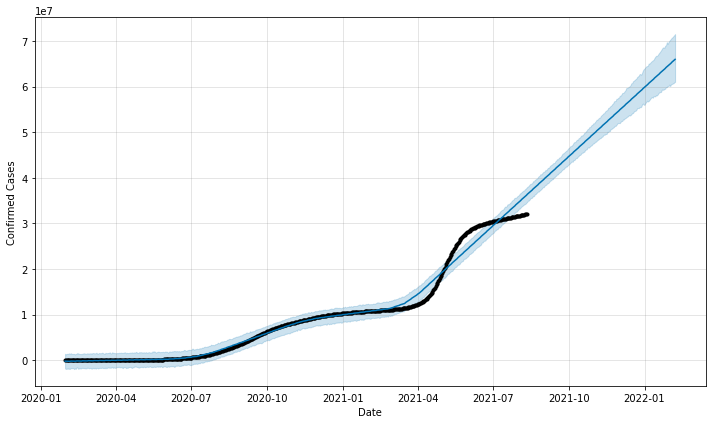

In [ ]:
Confirmed.columns = ['ds', 'y']

prop=Prophet()
prop.fit(Confirmed)
future=prop.make_future_dataframe(periods=180)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(180)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

In [ ]:
forecast_accuracy(prop_forecast.iloc[:-180 , :]['yhat'],Confirmed['y'])

{'corr': 0.9923986788889796,
 'mae': 719876.1697643042,
 'mape': 3752.2189709527825,
 'me': -24.765404866343097,
 'minmax': 3752.008022303322,
 'mpe': -3751.585808908245,
 'rmse': 1252890.8639378275}

In [ ]:
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# df_cv = cross_validation(prop, initial='500 days', period='20 days', horizon = '15 days')
# df_cv.head()
# df_p = performance_metrics(df_cv)
# df_p.head()

AUTO ARIMA

In [ ]:
auto_arima_model=auto_arima(Confirmed['y'],trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=11575.466, Time=1.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11605.851, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=11605.878, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=11605.872, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=11567.710, Time=1.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=11607.860, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=11573.171, Time=0.51 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=11632.525, Time=0.99 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=11602.443, Time=0.26 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=11607.151, Time=1.15 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=11571.204, Time=1.59 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=11569.583, Time=2.12 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 9.562 seconds


In [ ]:
arima = ARIMA(Confirmed['y'], order=(1, 2, 2)).fit()
forecast = arima.forecast(steps=180)
#pred = list(forecast[0])

start_date = Confirmed['ds'].max()
prediction_dates = []
for i in range(180):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
# plt.figure(figsize= (15,10))
# plt.xlabel("Dates",fontsize = 20)
# plt.ylabel('Total cases',fontsize = 20)
# plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

# plt.plot_date(y= forecast,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
# plt.plot_date(y=Confirmed['y'],x=Confirmed['ds'],linestyle = '-',color = 'blue',label = 'Actual');
# plt.legend();

In [ ]:
start = Confirmed[Confirmed['ds']=='2020-10-6'].index
end = Confirmed[Confirmed['ds']=='2021-05-28'].index
print(start,'to',end)

Int64Index([250], dtype='int64') to Int64Index([484], dtype='int64')


In [ ]:
predict_1= arima.predict(start=250+1 ,end=484+1, dynamic= False)
pred_future_1=arima.predict(start=len(Confirmed)+1,end=len(Confirmed)+(180),dynamic=False)

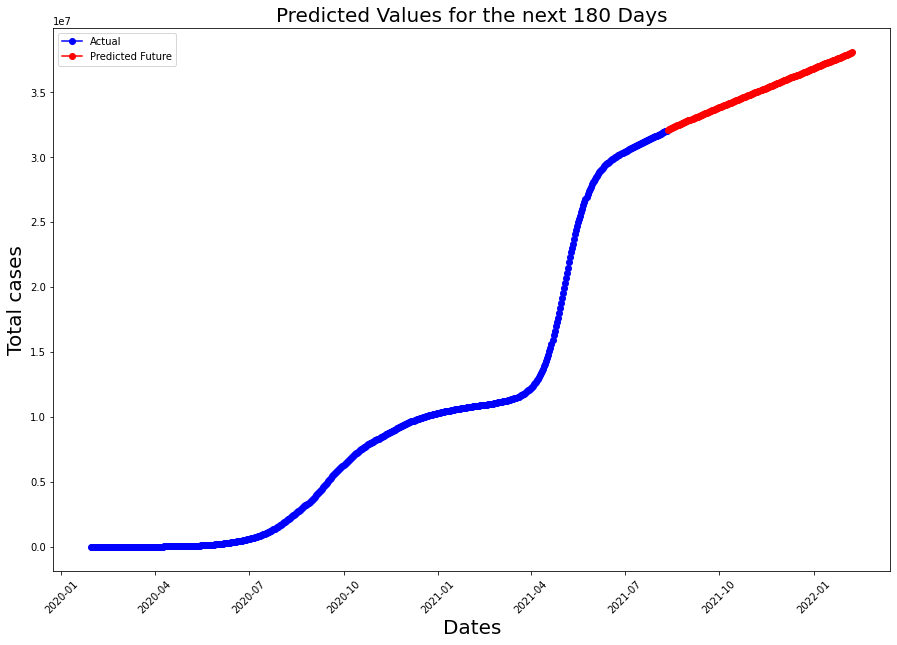

In [ ]:
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 180 Days" , fontsize = 20)

plt.plot_date(x=Confirmed['ds'],y=Confirmed['y'],color='blue',label='Actual',linestyle='solid')
#plt.plot_date(x=Confirmed['ds'].iloc[251:486],y=predict_1,color='yellow',label='Predicted Past',linestyle='solid')
plt.plot_date(x=prediction_dates,y=pred_future_1,color='red',label='Predicted Future',linestyle='solid')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
arima_train= arima.predict(start=0 ,end=len(Confirmed)-1, dynamic= False)

In [ ]:
# plt.figure(figsize= (15,10))
# plt.xlabel("Dates",fontsize = 20)
# plt.ylabel("Total cases",fontsize = 20)
# plt.title("Actual VS Predicted" , fontsize = 20)

# plt.plot_date(x=Confirmed['ds'],y=Confirmed['y'],color='blue',label='Actual',linestyle='solid')
# plt.plot_date(x=Confirmed['ds'].iloc[0:len(Confirmed)],y=arima_train,color='yellow',label='Predicted Past',linestyle='solid',markersize=2)
# #plt.plot_date(x=prediction_dates,y=pred_future_1,color='red',label='Predicted Future',linestyle='solid')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [ ]:
forecast_accuracy(arima_train, Confirmed['y'])

{'corr': 0.9999997221928887,
 'mae': 4304.741614625932,
 'mape': 0.014683590635049877,
 'me': -19.092285042324406,
 'minmax': 0.012991105045158213,
 'mpe': -0.0019160545368372191,
 'rmse': 7594.866902176898}

SARIMA

In [ ]:
# exons variables
exons=Trend[['Cured','Death']]
full_data = Trend['Confirmed']

In [ ]:
SARIMAX__model = sm.tsa.statespace.SARIMAX(full_data.values,exons=exons,
                                            order=(1,0,1),
                                            seasonal_order=(1,0,1,7),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False,)
SARIMAX__model = SARIMAX__model.fit(maxiter=1000)

days=180
prediction = SARIMAX__model.get_forecast(steps=days)
pred_date = prediction.summary_frame(alpha=0.05).set_index(pd.date_range(start='2021-08-11',periods=days,freq='D'))

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Actual",
     x=Trend['Date'], y=Trend["Confirmed"]))

fig.add_trace(go.Scatter(
    name="Prediction",mode="lines",
     x=pred_date.index, y=pred_date['mean']))

fig.add_trace(go.Scatter(
    name="lowerbound",mode="lines",
        line=dict(width=0),fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',showlegend=False,
     x=pred_date.index, y=pred_date['mean_ci_lower']))

fig.add_trace(go.Scatter(name="upperbound",mode="lines",
        line=dict(width=0),fillcolor='rgba(68, 68, 68, 0.3)',fill='tonexty',showlegend=False,
                         x=pred_date.index, y=pred_date['mean_ci_upper']))

fig.update_layout(title_text='Predicted Values for the next 180 Days', title_x=0.5, xaxis_title="Dates",
    yaxis_title="Confirmed")

In [ ]:
sarima_train=SARIMAX__model.predict(start=0 ,end=len(Confirmed)-1, dynamic= False)

In [ ]:
forecast_accuracy(sarima_train, Confirmed['y'])

{'corr': 0.9999991156022354,
 'mae': 6960.827570788399,
 'mape': 0.020114471805019546,
 'me': -916.715765926535,
 'minmax': 0.018871394250919216,
 'mpe': -0.008062974523342639,
 'rmse': 13764.309814177195}